In [1]:
using Pkg
#ENV["PYTHON"] = "/usr/local/bin/python3"           # example for *nix
#Pkg.build("PyCall")

In [2]:
using PyCall

In [3]:
cmd = pyimport("cmdtools")

PyObject <module 'cmdtools' from '/Users/alex/Documents/code/cmdtools/src/cmdtools/__init__.py'>

In [4]:
Q = cmd.systems.diffusion.DoubleWell(nx=13,beta=0.1).Q.todense()
K = exp(Q)

13×13 Array{Float64,2}:
 0.172451     0.390977     0.293061     …  8.65821e-9   3.06942e-10
 0.0758036    0.31735      0.356747        4.37093e-8   1.67867e-9
 0.0255383    0.160345     0.361291        2.95749e-7   1.24307e-8
 0.00723966   0.0607483    0.215296        2.30643e-6   1.07157e-7
 0.00173524   0.01825      0.0893244       1.83454e-5   9.52059e-7
 0.000346518  0.00438877   0.0275699    …  0.000134707  7.90521e-6
 5.72028e-5   0.000848848  0.00653459      0.000848848  5.72028e-5
 7.90521e-6   0.000134707  0.0012311       0.00438877   0.000346518
 9.52059e-7   1.83454e-5   0.000194505     0.01825      0.00173524
 1.07157e-7   2.30643e-6   2.78737e-5      0.0607483    0.00723966
 1.24307e-8   2.95749e-7   4.01553e-6   …  0.160345     0.0255383
 1.67867e-9   4.37093e-8   6.58001e-7      0.31735      0.0758036
 3.06942e-10  8.65821e-9   1.42647e-7      0.390977     0.172451

In [5]:
using Distributions
sample(x) = rand(Categorical(K[x,:]))

sample (generic function with 1 method)

In [6]:
b = fill(NaN,size(K,1))
b[1:2] .= 0
b[end-1:end] .= 1
b

13-element Array{Float64,1}:
   0.0
   0.0
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   1.0
   1.0

In [7]:
function committor(K, b)
    A = copy(K)
    b = copy(b)
    for i in 1:length(b)
        if isnan(b[i])
            b[i] = 0
            A[i,i] -= 1
        else
            A[i,:].=0
            A[i,i]=1
        end
    end
    A\b
end

c = committor(K,b)

13-element Array{Float64,1}:
 0.0
 0.0
 0.23850564648072406
 0.3049943675485864
 0.3678245091452863
 0.43242726633319084
 0.5000000000000013
 0.567572733666812
 0.6321754908547159
 0.6950056324514149
 0.7614943535192767
 1.0
 1.0

In [8]:
function risk(c; M=10, b=b)
    s = 0
    inds = findall(isnan,b)
    for x in inds
        mc=0
        for i in 1:M
            y = sample(x)
            mc += c[y]
        end
        s += abs(mc / M - c[x]) ^ 1
    end
    s / length(inds)
end

risk (generic function with 1 method)

In [9]:
using PyPlot

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/alex/.julia/packages/PyPlot/XHEG0/src/init.jl:192


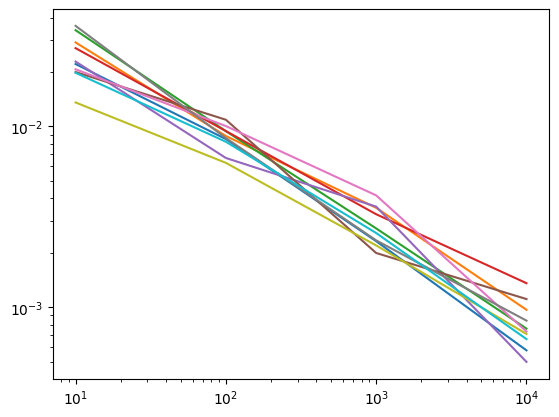

In [10]:
ms = [10^i for i in 1:4]
for i in 1:10
    plot(ms,[risk(c, M=m) for m in ms])
end
yscale("log")
xscale("log")

In [11]:
using ForwardDiff, Flux

In [12]:
using LinearAlgebra
error(x) = norm(x - c) / sqrt(length(x))

error (generic function with 1 method)

In [13]:
x0 = rand(length(c))
bndinds = findall(!isnan, b)
x0[bndinds] = b[bndinds]
x = copy(x0)

@show error(x)
x

opt = ADAM(0.001)
errors=[]
losses=[]

loss(x) = risk(x, M=100)

error(x) = 0.3290385201220804


loss (generic function with 1 method)

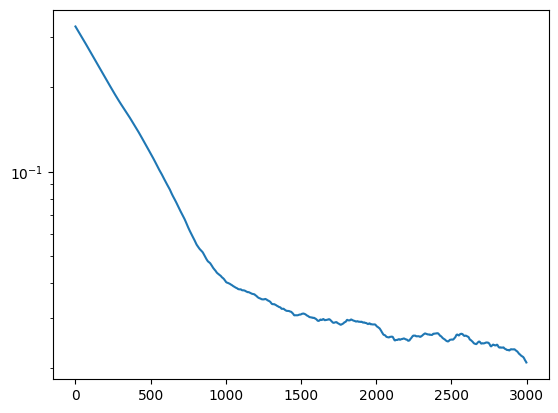

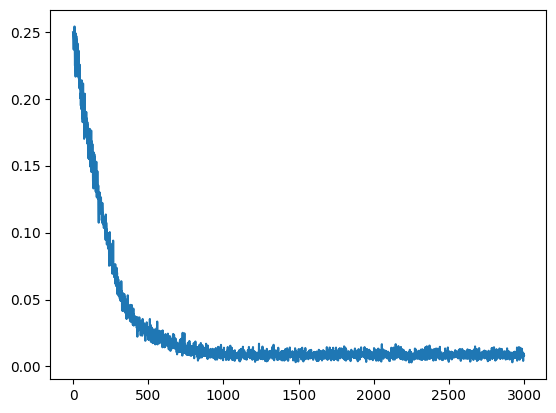

  1.847436 seconds (16.43 M allocations: 1.395 GiB, 10.73% gc time)
error(x) = 0.02090535761261045


1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1634fd8b0>

In [22]:
#ps = Flux.params(x)
#fg = Flux.gradient(loss, ps)

@time for i in 1:1000
    
    g = ForwardDiff.gradient(loss,x)
    
    Flux.Optimise.update!(opt, x, g)
    
    #g = Flux.gradient(loss, ps)
    #Flux.Optimise.update!(opt, ps, fg)
    
    x[bndinds] = b[bndinds]
    push!(errors, error(x))
    push!(losses, loss(x))
end
@show error(x)

PyPlot.plot(errors)
PyPlot.yscale(:log)
figure()
plot(losses)
#yscale(:log)

In [15]:
loss() = risk(x)

ps = Flux.params(x)
g = Flux.gradient(loss, ps)
g.grads

IdDict{Any,Any} with 2 entries:
  :(Main.x)                 => [0.0, 0.0111111, -0.0444444, -0.0333333, 0.01111…
  [0.0, 0.0, 0.230222, 0.2… => [0.0, 0.0111111, -0.0444444, -0.0333333, 0.01111…

In [16]:
Flux.Optimise.update!(opt, ps, g)

In [17]:
x

13-element Array{Float64,1}:
 0.00013942004978475045
 0.00028087675254795554
 0.23029596524018023
 0.2895596280675511
 0.34153832085671415
 0.39772530163679376
 0.4524654635516999
 0.5078987617401413
 0.5661255202083931
 0.6236920187343088
 0.6988649384973337
 0.9992888642583272
 0.9993936987385519

In [18]:
g.grads

IdDict{Any,Any} with 2 entries:
  :(Main.x)                 => [-0.00013942, -0.000280877, -7.38202e-5, -0.0001…
  [0.00013942, 0.000280877… => [-0.00013942, -0.000280877, -7.38202e-5, -0.0001…

In [19]:
g=gradient(loss, Flux.params(x))

Grads(...)

In [20]:
g[x]

13-element Array{Float64,1}:
  0.0
  0.011111111111111112
 -0.06666666666666665
  0.011111111111111136
  0.02222222222222224
 -0.03333333333333331
 -0.011111111111111087
 -0.011111111111111087
  0.07777777777777777
 -0.12222222222222225
  0.13333333333333333
 -0.011111111111111112
  0.0